In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [67]:
# Load dataset
dataset = "results/all_vec.csv"
data_list = np.genfromtxt(dataset)
data_list = data_list.astype(float)
print("Dataset size: ", data_list.shape)

Dataset size:  (764137, 100)


In [68]:
# Set hyperparameters
train_encoding = 10000 # number of packets to train packet feature encoding on
train_clusters = 100000 # number of packets to train clustering module on
W_seg = 50 # framing length 
C = 10 # adjustment in log transform
K = 10 # number of clusters

In [69]:
# Get feature encodings using PCA
train_encoding_data = data_list[:train_encoding]
pca = PCA(n_components=30)
pca.fit(train_encoding_data)


PCA(n_components=30)

In [70]:
# Transform the remaining data using the learned PCA
remaining_data = data_list[train_encoding:]
embedded_data = pca.transform(remaining_data)

In [71]:
n_packets = embedded_data.shape[0]
n_frames = n_packets // W_seg
print("Number of packets: ", n_packets)
print("Number of frames: ", n_frames)

Number of packets:  754137
Number of frames:  15082


In [72]:
# Initialize a list to store the modulus of DFT outputs
modulus_dft = []

# Perform DFT on each frame and calculate the modulus
for i in range(n_frames):
    frame = embedded_data[i*W_seg:(i+1)*W_seg]
    dft_output = np.fft.fft(frame)
    modulus_output = np.abs(dft_output)
    modulus_dft.append(modulus_output)
modulus_dft = np.array(modulus_dft)

print("Modulus DFT shape: ", modulus_dft.shape)

Modulus DFT shape:  (15082, 50, 30)


In [73]:
# Apply log transform to modulus of DFT outputs
log_modulus_dft = np.log2(modulus_dft + np.ones(modulus_dft.shape))/C

# Check for NaN and Inf values
nan_mask = np.isnan(log_modulus_dft)
inf_mask = np.isinf(log_modulus_dft)
print("NaN values: ", np.sum(nan_mask))
print("Inf values: ", np.sum(inf_mask))

# Replace NaN and Inf values with 0
log_modulus_dft = np.where(nan_mask | inf_mask, 0, log_modulus_dft)

NaN values:  0
Inf values:  0


In [74]:
train_clusters = train_encoding // W_seg
train_data = np.mean(log_modulus_dft[:train_clusters], axis=2)
test_data = np.mean(log_modulus_dft[train_clusters:], axis=2)
all_data = np.mean(log_modulus_dft, axis=2)

# Fit KMeans clustering model on training data
kmeans = KMeans(n_clusters=K, n_init='auto')
kmeans.fit(train_data)

KMeans(n_clusters=10, n_init='auto')

In [75]:
def get_l2_distances(dataset, kmeans):
    # Find the closest cluster center for each data point
    closest_cluster_centers = kmeans.cluster_centers_[kmeans.predict(dataset)]

    # Calculate the L2 distance between each data point and its closest cluster center
    l2_distances = np.linalg.norm(dataset - closest_cluster_centers, axis=1)
    print("L2 distances mean: ", np.mean(l2_distances))
    print("L2 distances std: ", np.std(l2_distances))
    return l2_distances

L2 distances mean:  2.0519309115140483
L2 distances std:  0.6726580134468318


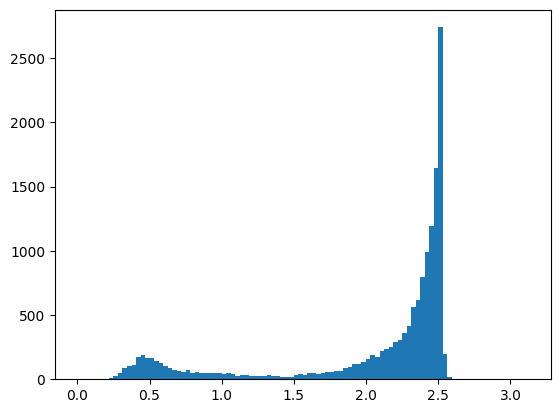

In [76]:
# Plot histogram of l2 distances
plt.hist(get_l2_distances(all_data, kmeans), bins=100)
plt.show()

In [77]:
# Convert from frames back to packets
num_data_pts = data_list.shape[0]
l2_distances = get_l2_distances(all_data, kmeans)
l2_dist_packet = np.append(np.zeros(train_encoding),np.repeat(l2_distances, W_seg))
print("L2 distances shape: ", l2_dist_packet.shape)


L2 distances mean:  2.0519309115140483
L2 distances std:  0.6726580134468318
L2 distances shape:  (764100,)


In [78]:
labels = "mirai_labels.csv"
labels_list = np.genfromtxt(labels)
labels_list = labels_list.astype(float)
print("Labels shape: ", labels_list.shape)

Labels shape:  (764137,)


In [79]:
anomaly_dist = []
normal_dist = []
anomaly_indices = []
for i in range(l2_dist_packet.shape[0]):
    if labels_list[i] == 1:
        anomaly_dist.append(l2_dist_packet[i])
        anomaly_indices.append(i)
    elif i > train_encoding:
        normal_dist.append(l2_dist_packet[i])

normal_dist = np.array(normal_dist)
anomaly_dist = np.array(anomaly_dist)
anomaly_indices = np.array(anomaly_indices)
# np.save("results/normal_dist.npy", normal_dist)
# np.save("results/anomaly_dist.npy", anomaly_dist)
# np.save("results/anomaly_indices.npy", anomaly_indices)

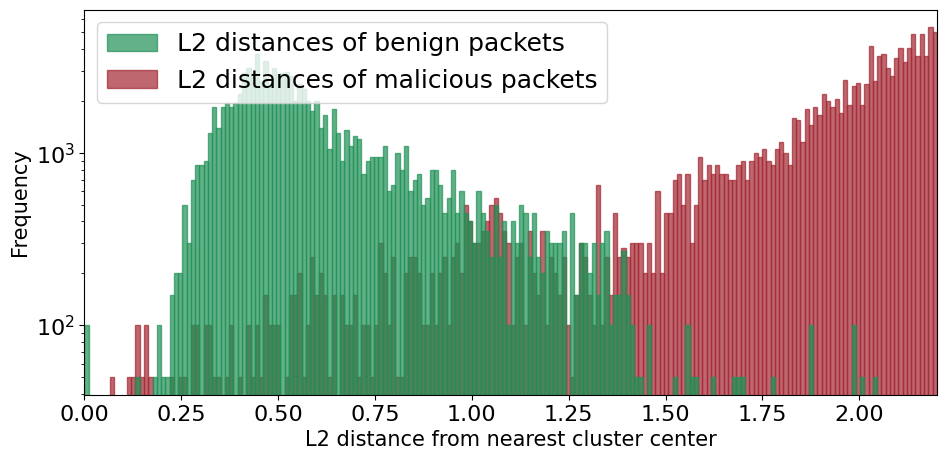

In [80]:
plt.figure(figsize=(11,5))
x_max = 2.2
plt.xlim(0, x_max)
bin_list = [x_max/200.0 * i for i in range(201)]
n, bins, patches = plt.hist(anomaly_dist, bins=bin_list, facecolor='g', label="L2 distances of malicious packets", log=True)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
for c, p in zip(bin_centers, patches):
    plt.setp(p, color='#a32632', alpha=0.7)

n, bins, patches = plt.hist(normal_dist, bins=bin_list, facecolor='g', label="L2 distances of benign packets", log=True)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
for c, p in zip(bin_centers, patches):
    plt.setp(p, color='#1f9156', alpha=0.7)

plt.xlabel("L2 distance from nearest cluster center", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), loc="upper left", fontsize=18)    
plt.show()

In [84]:
# Calculate AUC of ROC curve
def get_roc_auc(normal_rmses, anomaly_rmses, sample_size=20000):
    normal_rmses = np.random.choice(normal_rmses, sample_size)
    anomaly_rmses = np.random.choice(anomaly_rmses, sample_size)
    roc_auc = 0
    for normal_rmse in normal_rmses:
        for anomaly_rmse in anomaly_rmses:
            if anomaly_rmse > normal_rmse:
                roc_auc += 1
    roc_auc /= (sample_size * sample_size)
    return roc_auc

In [85]:
get_roc_auc(normal_dist, anomaly_dist)

0.9926186075